<a href="https://colab.research.google.com/github/yu828282/TIL/blob/master/AI/%EC%82%BC%EC%84%B1%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 데이터셋 생성
df_price = pd.read_csv(os.path.join('/content/', '01-삼성전자-주가.csv'), encoding='utf8')
df_price.describe()

,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


In [19]:
pd.to_datetime(df_price['일자'], format='%Y%m%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

Text(0, 0.5, 'price')

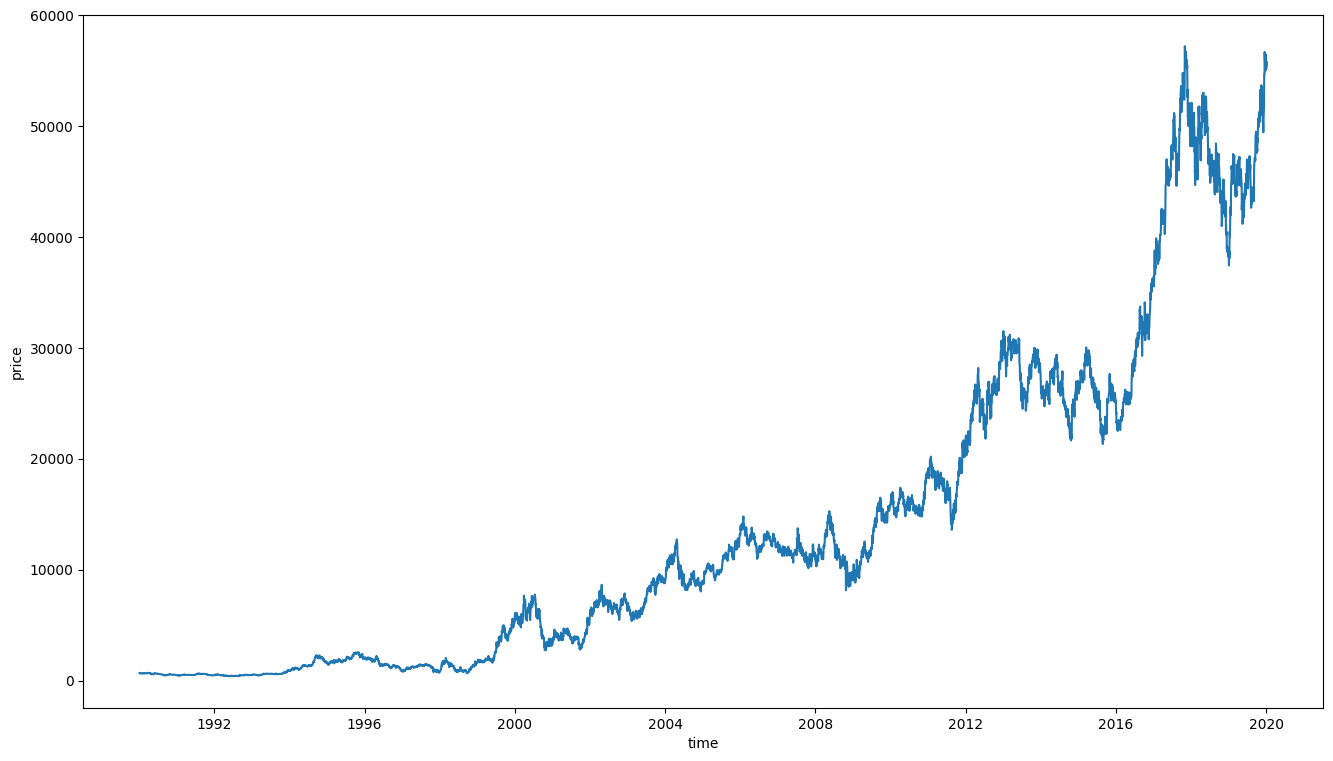

In [20]:
df = df_price.loc[df_price['연도']>=1990]

# 1990년도 이후의 주가 시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

In [21]:
# 0, 1사이의 값을 가지도록 정규화

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.030291
1,0.954474,0.966389,0.961684,0.969733,0.031470
2,0.973735,0.983895,0.967005,0.969733,0.047217
3,0.964980,0.973391,0.968779,0.964454,0.039781
4,0.977237,0.983895,0.981197,0.975012,0.025585
...,...,...,...,...,...
7823,0.005095,0.005094,0.005073,0.004927,0.002960
7824,0.005165,0.005129,0.005215,0.005068,0.005279
7825,0.005236,0.005199,0.005162,0.005015,0.005483
7826,0.005236,0.005339,0.005286,0.005279,0.008384


In [24]:
# 학습시킬 데이터 셋 생성

TEST_SIZE = 200

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=20): # 20일을 기반으로 데이터 예측
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

# feature 와 label 정의
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 4), (180, 1))

In [25]:
# Keras를 활용한 LSTM 모델 생성

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
          )
model.add(Dense(1))

In [28]:
# 모델의 학습
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop, checkpoint])

# ...
# ...

# Epoch 00015: val_loss did not improve from 0.00002
# Epoch 16/200
# 6086/6086 [==============================] - 12s 2ms/step - loss: 3.1661e-05 - val_loss: 4.1063e-05

# Epoch 00016: val_loss did not improve from 0.00002
# Epoch 17/200
# 6086/6086 [==============================] - 13s 2ms/step - loss: 2.4644e-05 - val_loss: 4.0085e-05

# Epoch 00017: val_loss did not improve from 0.00002
# Epoch 18/200
# 6086/6086 [==============================] - 13s 2ms/step - loss: 2.2936e-05 - val_loss: 2.4692e-05

# Epoch 00018: val_loss did not improve from 0.00002

Epoch 1/200
370/381 [============================>.] - ETA: 0s - loss: 0.0109
Epoch 1: val_loss improved from inf to 0.00007, saving model to tmp_checkpoint.h5
381/381 [==============================] - 4s 7ms/step - loss: 0.0106 - val_loss: 7.4696e-05
Epoch 2/200
374/381 [============================>.] - ETA: 0s - loss: 7.1532e-05
Epoch 2: val_loss improved from 0.00007 to 0.00007, saving model to tmp_checkpoint.h5
381/381 [==============================] - 2s 5ms/step - loss: 7.1445e-05 - val_loss: 7.1678e-05
Epoch 3/200
377/381 [============================>.] - ETA: 0s - loss: 6.7480e-05
Epoch 3: val_loss improved from 0.00007 to 0.00007, saving model to tmp_checkpoint.h5
381/381 [==============================] - 3s 7ms/step - loss: 6.7542e-05 - val_loss: 6.6906e-05
Epoch 4/200
379/381 [============================>.] - ETA: 0s - loss: 6.7524e-05
Epoch 4: val_loss did not improve from 0.00007
381/381 [==============================] - 2s 6ms/step - loss: 6.7636e-05 - val_loss: 9.

In [29]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

6/6 [==============================] - 0s 3ms/step


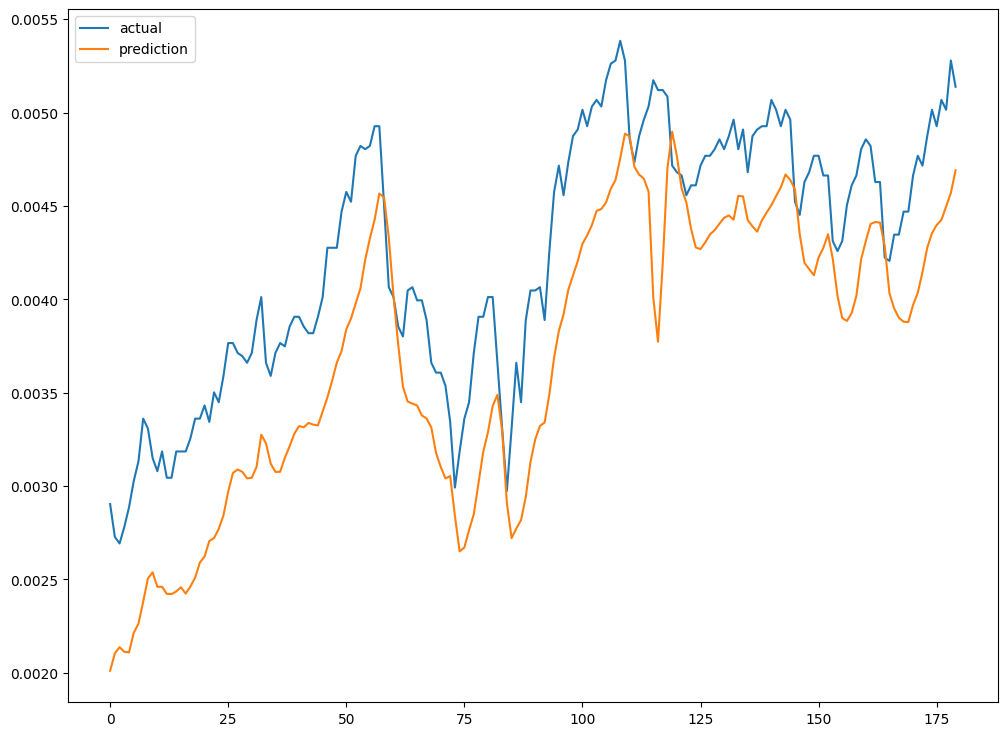

In [30]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()